# Deconvolution

Images acquired on a microscope are blurred as the result of the diffraction of the light collected by the objective. The blur can be modelled as convolution of the image by the point spread function (PSF). The optical transfer function is defined as the Fourier transform of the PSF and the convolution theorem indicates that the Fourier transform (FT) of the recorded image is the product of the optical transfer function and the FT of the sample. The optical transfer function is zero beyond the diffraction limit defined in the xy plane as half the ratio of the wavelength and the numerical aperture of the objective. This result as unobservable frequencies in the acquired image.

Recovering the fluorophore density of the sample from an acquired image amount at inversing the convolution process and is called deconvolution. As convolution is the product of the OTF by the FT of the sample, deconvolution should be the division of the FT of the image by the OTF. However, the OTF being zero outside the resolution limit, the division is ill posed and simply amplify the noise of the acquired image.

Various strategies can be used then to recover the fine structure of the sample whilst mitigating the noise amplification. 

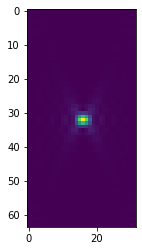

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

def generate_otf3d_grid(shape, pixel_size):
    """
    Generate a grid on which to evaluate the optical transfer function
    Parameters
    ----------
    shape : list [nx,ny,nz] giving the shape of the final array
    pixel_size : sampling in [x,y,z]    
    Returns
    -------
    kx,ky,kz,z: frequency grid in x and y and spatial space in z
    """
    f = [np.fft.fftfreq(n, pixel_size[k]) for k, n in enumerate(shape)]
    ez = np.concatenate((np.arange(0,shape[2]//2), np.arange((-shape[2])//2,0))) * pixel_size[2]
    [kx,ky,kz] = np.meshgrid(*f)
    z = np.meshgrid(f[0],f[1],ez)[2]
    return kx,ky,kz,z

def generate_otf3d_on_grid(grid,NA,wavelength,medium_refractive_index):
    """
    Generate a diffraction limited wide field optical transfer function and point spread function
    Parameters
    ----------
    grid : tuple [kx,ky,z] with grid on which to evaluate the otf
    pixel_size : sampling in [x,y,z]
    NA : numerical aperture
    wavelength : wavelength of the emitted light
    medium_refractive_index : refractive index of the immersion medium
    Returns
    --------
    otf : the optical transfer function as an array of shape 'shape'
    psf : the point spread function as an array of shape 'shape' centerd in 0,0,0
    """
    d2 = np.square(grid[0]) + np.square(grid[1])
    rho = np.sqrt(d2) * wavelength / NA
    P = np.where(rho <= 1.0, 1.0, 0.0)
    defocus = grid[3] * np.sqrt(np.clip((medium_refractive_index / wavelength)**2 - d2,0,None))
    psf = np.square(np.abs(np.fft.fft2(P * np.exp(2j * math.pi * defocus),axes=[0,1])))
    psf = psf / psf.sum()
    otf = np.fft.fftn(psf)
    return otf, psf

def generate_otf3d(shape,pixel_size,wavelength,NA,medium_refractive_index):
    """
    Generate a diffraction limited wide field optical transfer function and point spread function
    Parameters
    ----------
    shape : list [nx,ny,nz] giving the shape of the final array
    pixel_size : sampling in [x,y,z]
    NA : numerical aperture
    wavelength : wavelength of the emitted light
    medium_refractive_index : refractive index of the immersion medium
    Returns
    --------
    otf : the optical transfer function as an array of shape 'shape'
    psf : the point spread function as an array of shape 'shape' centerd in 0,0,0
    """
    grid = generate_otf3d_grid(shape, pixel_size)
    return generate_otf3d_on_grid(grid,NA,wavelength,medium_refractive_index)
    
shape = [64,64,32] 
pixel_size = [100,100,300] 
wavelength = 500
NA = 1
medium_refractive_index = 1.3
otf,psf = generate_otf3d(shape,pixel_size,wavelength,NA,medium_refractive_index)
plt.imshow(np.fft.fftshift(psf[:,0,:]))

Text(0.5, 1.0, 'Simulated sample')

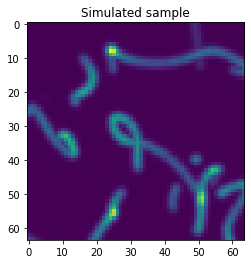

In [2]:
import scipy.ndimage

def generate_test_image(shape,N=10,L=100,smooth=10):
    """
    Generate a test image with fibers

    Parameters
    ----------
    shape : list of int giving the shape of the generated image
    N : number of fibers
    L : number of points in each fiber
    smooth : smoothness of the fibers
    
    Output
    ------
    img : numpy array of given shape normalized between 0 and 1
    """
    D = len(shape)
    # generate points on smooth curves as a N x L x D array
    P = np.tile(np.repeat(np.reshape(np.array(shape), [1,1,D]), N, axis=0) * (.1 + .8 * np.random.rand(N,1,D)), [1,L,1])
    P = P + np.cumsum(scipy.ndimage.gaussian_filter1d(2*np.random.randn(N,L,D), smooth, axis=1),axis=1)
    space = tuple([np.arange(k) for k in shape])
    X = np.meshgrid(*space)
    img = np.zeros(shape)
    for p in np.reshape(P,(N*L,D)):
        img = img + np.exp(-0.5*np.sum(np.stack([np.square(p[k]-X[k]) for k in range(D)]), axis=0))
    img = img / img.max()
    return img

img = generate_test_image(shape,10,100)
plt.imshow(np.amax(img,axis=2))
plt.title('Simulated sample')

To simulate an image acquired by a microscope, we multiply in Fourier space the sample by the optical transfer function. We also add some Poisson noise to emulate the photon limited nature of the acquisition process.

Text(0.5, 1.0, 'Simulated data')

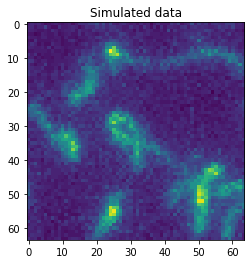

In [3]:
data = 1000 * np.real(np.fft.ifftn(np.fft.fftn(img) * otf))
data = np.random.poisson(data)
plt.imshow(np.amax(data, 2))
plt.title('Simulated data')

We have simulated a realistic image. We will now try to recover the original sample using a deconvolution algorithm. We implement here the Richardson-Lucy deconvolution.

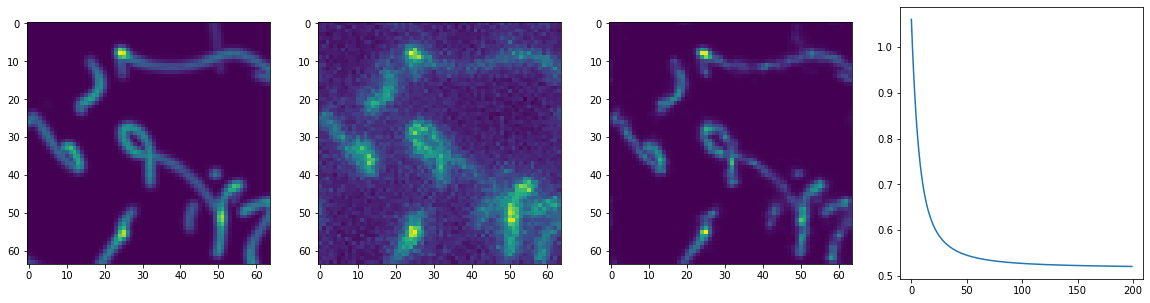

In [4]:
def kulback_leibler_divergence(data,estimate,otf,background):
    """
    Compute the kullback Leibler divergence
    Parameters
    ----------
    data       : numpy array 
    estimate   : estimate
    otf        : numpy array of the same size than data
    background : background level
    Result
    ------
    The kullback Leibler divergence
    """
    blurred = np.real(np.fft.ifftn(otf * np.fft.fftn(estimate+background)))
    return np.mean(blurred - data + data * np.log(np.clip(data/blurred,a_min=1e-6,a_max=None))) 

def deconvolve_richardson_lucy(data, otf, background=0, iterations=100):
    """ 
    Deconvolve data according to the given otf using a Richardson-Lucy algorithm
    Parameters
    ----------
    data       : numpy array
    otf        : numpy array of the same size than data
    background : background level
    iterations : number of iterations
    Result
    ------
    estimate   : estimated image
    """
    estimate = np.clip(np.real(np.fft.ifftn(otf * np.fft.fftn(data-background))), a_min=1e-6, a_max=None)
    dkl = np.zeros(iterations)
    for k in range(iterations):
        blurred = np.clip(np.real(np.fft.ifftn(otf * np.fft.fftn(estimate+background))), a_min=1e-6, a_max=None)
        ratio = data / blurred
        estimate = estimate * np.real(np.fft.ifftn(otf * np.fft.fftn(ratio)))
        dkl[k] = kulback_leibler_divergence(data,estimate,otf,background)
    return estimate,dkl

deconvolved1, dkl1 = deconvolve_richardson_lucy(data,otf,0,200)
fig, ax = plt.subplots(1,4,figsize=[20,5])
ax[0].imshow(np.amax(img, 2))
ax[1].imshow(np.amax(data, 2))
ax[2].imshow(np.amax(deconvolved1, 2))
ax[3].plot(dkl1)

Let's now implement an accelerate version of the Richardson Lucy using the principle of heavy ball acceleration.

MSE11 1226.1146068266214 MSE2 3475.353208868148


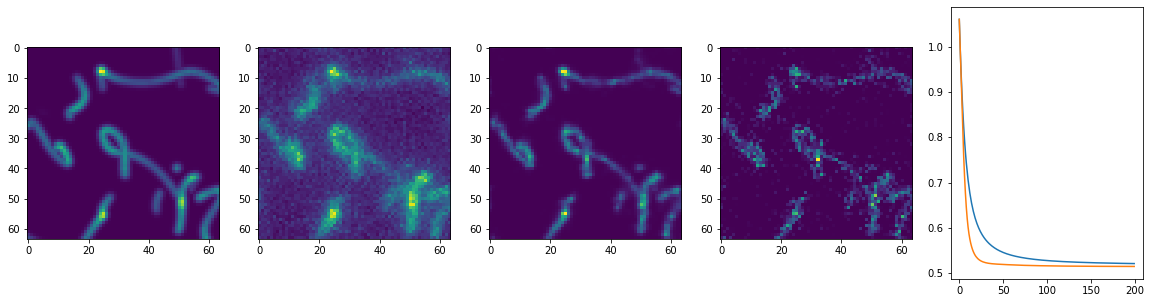

In [5]:
def deconvolve_richardson_lucy_heavy_ball(data, otf, background, iterations):
    """ 
    Deconvolve data according to the given otf using a scaled heavy ball Richardson-Lucy algorithm
    Parameters
    ----------
    data       : numpy array
    otf        : numpy array of the same size than data
    iterations : number of iterations
    Result
    ------
    estimate   : estimated image
    dkl        : the kullback leibler divergence (should tend to 1/2)
    Note
    ----
    https://doi.org/10.1109/tip.2013.2291324
    """
    estimate = np.clip(np.real(np.fft.ifftn(otf * np.fft.fftn(data))), a_min=0, a_max=None)
    old_estimate = estimate
    dkl = np.zeros(iterations)
    for k in range(iterations):
        beta = (k-1) / (k+2)
        alpha = estimate
        prediction = estimate + beta * (estimate -  old_estimate)
        blurred = np.clip(np.real(np.fft.ifftn(otf * np.fft.fftn(prediction))), a_min=1e-6, a_max=None)
        ratio = data / blurred
        gradient = 1.0 - np.real(np.fft.ifftn(otf * np.fft.fftn(ratio)))
        old_estimate = estimate
        estimate = np.clip(prediction - alpha * gradient, a_min=0.1, a_max=None)
        dkl[k] = kulback_leibler_divergence(data, estimate, otf, background)
    return estimate, dkl

deconvolved2,dkl2 = deconvolve_richardson_lucy_heavy_ball(data, otf, 0, 200)
fig, ax = plt.subplots(1,5,figsize=[20,5])
ax[0].imshow(np.amax(img, 2))
ax[1].imshow(np.amax(data, 2))
ax[2].imshow(np.amax(deconvolved1, 2))
ax[3].imshow(np.amax(deconvolved2, 2))
ax[4].plot(dkl1)
ax[4].plot(dkl2)
mse1 = np.mean(np.square(deconvolved1 - img))
mse2 = np.mean(np.square(deconvolved2 - img))
print(f'MSE11 {mse1} MSE2 {mse2}' )


1.10.0.dev20210913


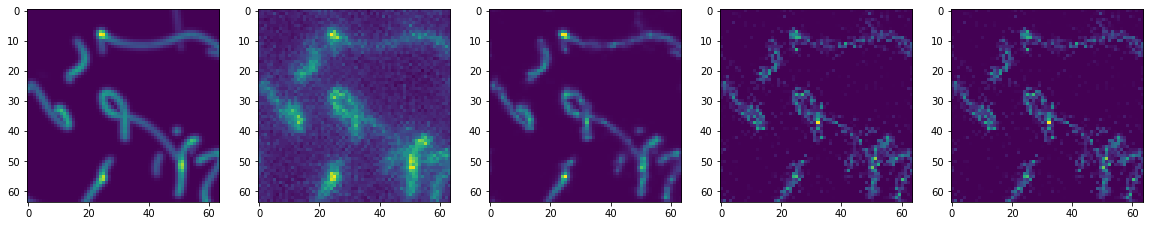

In [51]:
import torch

def deconvolve_richardson_lucy_heavy_ball_torch(data, otf, background, iterations):
    """ 
    Deconvolve data according to the given otf using a scaled heavy ball Richardson-Lucy algorithm
    Parameters
    ----------
    data       : torch tensor
    otf        : optical transfer function
    background : bakground level
    iterations : number of iterations
    Result
    ------
    estimate   : estimated image
    dkl        : the kullback leibler divergence (should tend to 1/2)
    Note
    ----
    https://doi.org/10.1109/tip.2013.2291324
    Need a recent version of pytorch (>1.9))
    """
    data = torch.from_numpy(data.astype(complex))
    otf = torch.from_numpy(otf.astype(complex))
    estimate = torch.clamp(torch.real(torch.fft.ifftn(otf * torch.fft.fftn(data))), min=1e-6)
    old_estimate = estimate
    dkl = torch.zeros(iterations,dtype=float)
    for k in range(iterations):
        beta = (k-1) / (k+2)
        #alpha = estimate
        prediction = estimate + beta * (estimate -  old_estimate)
        blurred = torch.clamp(torch.real(torch.fft.ifftn(otf * torch.fft.fftn(prediction))), min=1e-6)
        ratio = data / blurred
        gradient = 1.0 - torch.real(torch.fft.ifftn(otf * torch.fft.fftn(ratio)))
        old_estimate = estimate
        estimate = torch.clamp(prediction - estimate * gradient, min=0.1)
        dkl[k] = torch.mean(blurred - data + data * torch.log(torch.clamp(torch.real(ratio),min=1e-6)))
    return estimate.numpy(), dkl.numpy()

print(torch.__version__)

deconvolved3, dkl = deconvolve_richardson_lucy_heavy_ball_torch(data, otf, 0, 200)
fig, ax = plt.subplots(1,5,figsize=[20,5])
ax[0].imshow(np.amax(img, 2))
ax[1].imshow(np.amax(data, 2))
ax[2].imshow(np.amax(deconvolved1, 2))
ax[3].imshow(np.amax(deconvolved3, 2))
ax[4].imshow(np.amax(deconvolved3, 2))



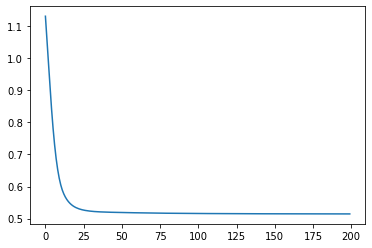

In [52]:
plt.plot(dkl)